# Train AE model to have committor as encoder

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

Imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from potentials.MullerBrown import MullerBrown
from simulations.UnbiasedMD import OverdampedLangevin

Generate dataset

In [4]:
pot = MullerBrown()

In [5]:
beta = 0.05
dt = 0.0005
unbiased_OL_on_MB = OverdampedLangevin(pot, beta, dt=dt)
x_0 = pot.minP
n_steps = 10**5

In [6]:
traj_dict = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=True, save_gauss=True)

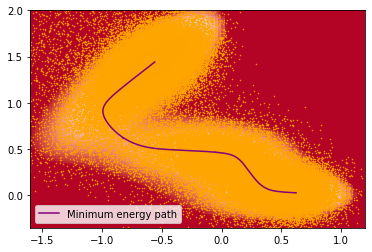

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ax.scatter(traj_dict["x_traj"][:, 0], traj_dict["x_traj"][:, 1], marker=".", color="orange", s=1)
ax.legend()

In [8]:
dataset = np.append(traj_dict["x_traj"][:-1, :], traj_dict["gauss_traj"][:-1, :], axis=1)
dataset = np.append(dataset, traj_dict["x_traj"][1:, :], axis=1)
dataset = {"any_distrib" : dataset, "beta" : beta, "dt" : dt}
dataset.keys()

dict_keys(['any_distrib', 'beta', 'dt'])

Import class for committor AE model and its training

In [9]:
from committor.neural_net_models import CommittorOneDecoder
from committor.train_committor import TainCommittorOverdampedOneDecoder

Define the model 

In [10]:
committor = CommittorOneDecoder([2, 5, 1], [1, 10, 10, 2], 0, pot)

Create training object 

In [11]:
committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dataset)

Do train test splitt of the dataset 

In [12]:
committor_training.train_test_split(train_size=8 * 10**4)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)

Set the optimizer 

In [13]:
committor_training.set_optimizer('Adam', 0.005)

Set the loss function parameters 

In [14]:
loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["n_wait"] = 50
committor_training.set_loss_weight(loss_params)

squared_grad_boltz_weight value not provided, set to default value of:  0.0
squared_grad_react_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0
pen_points_weight value not provided, set to default value of:  0.0


In [15]:
batch_size = 100
max_epochs = 100

In [16]:
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 61 epochs.



Plot the evolution of the loss stating from the 10th epoch 

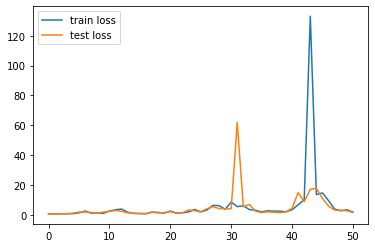

In [17]:
plt.figure()
plt.plot(loss_dict["train_loss"][10:], label='train loss')
plt.plot(loss_dict["test_loss"][10:], label='test loss')
plt.legend()

Plot committor iso-levels 

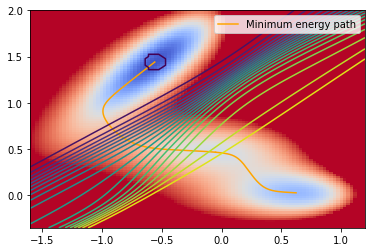

In [18]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
committor_training.plot_committor_iso_levels(ax, 20)
ax.legend()

/tmp/ipykernel_9015/3770637237.py:5: RuntimeWarning: divide by zero encountered in log
  contour0 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_9015/3770637237.py:11: RuntimeWarning: divide by zero encountered in log
  contour0 = ax2.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


Text(0.5, 1.0, 'log 1 - committor iso-levels')

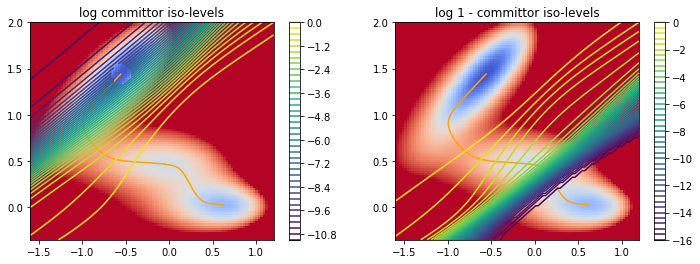

In [29]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) 
pot.plot_potential_heat_map(ax1)
ax1.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax1.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
contour0 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour0, ax=ax1) 
ax1.set_title("log committor iso-levels")
pot.plot_potential_heat_map(ax2)
ax2.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax2.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
contour0 = ax2.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour0, ax=ax2) 
ax2.set_title("log 1 - committor iso-levels")

1.0

In [19]:
xi_on_grid = committor_training.committor_model.xi(pot.x2d).reshape([100, 100])

In [21]:
np.max(xi_on_grid)

1.0

In [ ]:
import torch 

In [ ]:
X = committor_training.train_data[:10]
X.requires_grad_()
comm = committor_training.committor_model.committor(X[:, :2])
grad_xi_dot_gauss = np.sqrt(2 * dataset['dt'] / dataset['beta']) * torch.sum(torch.autograd.grad(outputs=comm.sum(), inputs=X, retain_graph=True, create_graph=True)[0][:, :2] * X[:, 2:4], dim=1)

In [ ]:
X.shape

In [ ]:
grad_xi_dot_gauss.shape